# 1. Import Library

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from torchvision.models import resnet18

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device yang digunakan:", device)

Device yang digunakan: cuda


# 2. Early Stopping

In [2]:
class EarlyStopping:
    def __init__(self, patience=7):
        self.patience = patience
        self.best_loss = None
        self.counter = 0

    def step(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience


# 3. Dataset Loader

In [3]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_ds = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\train", transform)
val_ds   = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\val", transform)
test_ds  = datasets.ImageFolder(r"C:\Users\IKBAR\uap_ML\src\dataset\Coffe_Bean\test", transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

class_names = train_ds.classes

# 4. Model Resnet18

# a. Model

In [7]:
model = resnet18(pretrained=True)
for p in model.parameters():
    p.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 4)
model = model.to(device)

# b. Training

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stop = EarlyStopping()

train_loss, val_loss, train_acc, val_acc = [], [], [], []

for epoch in range(50):
    model.train()
    correct = total = loss_sum = 0

    for x,y in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        correct += (out.argmax(1)==y).sum().item()
        total += y.size(0)

    train_loss.append(loss_sum/len(train_loader))
    train_acc.append(correct/total)

    model.eval()
    correct = total = loss_sum = 0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out,y)

            loss_sum += loss.item()
            correct += (out.argmax(1)==y).sum().item()
            total += y.size(0)

    val_loss.append(loss_sum/len(val_loader))
    val_acc.append(correct/total)

    print(f"Epoch {epoch+1} | Train Acc {train_acc[-1]:.4f} | Train Loss {train_loss[-1]:.4f} | Val Acc {val_acc[-1]:.4f} | Val Loss {val_loss[-1]:.4f}")

    if early_stop.step(val_loss[-1]):
        print("Early stopping")
        break

Epoch 1 | Train Acc 0.3812 | Train Loss 1.3542 | Val Acc 0.5825 | Val Loss 1.1020
Epoch 2 | Train Acc 0.7417 | Train Loss 0.9412 | Val Acc 0.8575 | Val Loss 0.7704
Epoch 3 | Train Acc 0.8686 | Train Loss 0.7102 | Val Acc 0.9125 | Val Loss 0.5990
Epoch 4 | Train Acc 0.9064 | Train Loss 0.5727 | Val Acc 0.9275 | Val Loss 0.4743
Epoch 5 | Train Acc 0.9231 | Train Loss 0.4843 | Val Acc 0.9525 | Val Loss 0.3866
Epoch 6 | Train Acc 0.9329 | Train Loss 0.4192 | Val Acc 0.9700 | Val Loss 0.3360
Epoch 7 | Train Acc 0.9402 | Train Loss 0.3746 | Val Acc 0.9675 | Val Loss 0.2985
Epoch 8 | Train Acc 0.9469 | Train Loss 0.3376 | Val Acc 0.9700 | Val Loss 0.2687
Epoch 9 | Train Acc 0.9493 | Train Loss 0.3119 | Val Acc 0.9700 | Val Loss 0.2445
Epoch 10 | Train Acc 0.9421 | Train Loss 0.2941 | Val Acc 0.9625 | Val Loss 0.2262
Epoch 11 | Train Acc 0.9574 | Train Loss 0.2610 | Val Acc 0.9725 | Val Loss 0.2050
Epoch 12 | Train Acc 0.9545 | Train Loss 0.2559 | Val Acc 0.9700 | Val Loss 0.1976
Epoch 13 | Tr

# 5. Evaluasi & Visualisasi

## a. Classification Report

In [10]:
y_true, y_pred = [], []
model.eval()

with torch.no_grad():
    for x,y in test_loader:
        out = model(x.to(device))
        y_true.extend(y.numpy())
        y_pred.extend(out.argmax(1).cpu().numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        Dark       0.99      0.98      0.98       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       0.98      0.99      0.99       100

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



## b. Grafik Loss & Accuracy

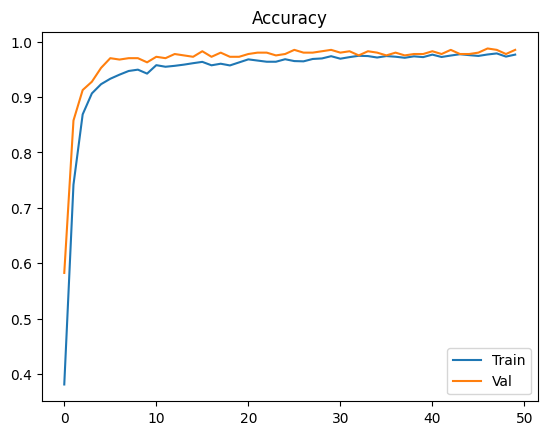

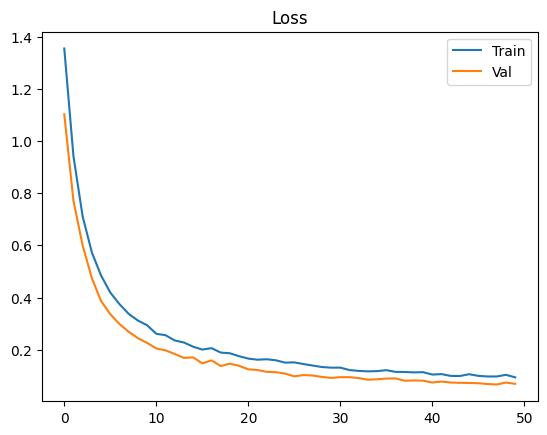

In [11]:
plt.plot(train_acc,label="Train")
plt.plot(val_acc,label="Val")
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(train_loss,label="Train")
plt.plot(val_loss,label="Val")
plt.title("Loss")
plt.legend()
plt.show()


## c. Confusion Matrix

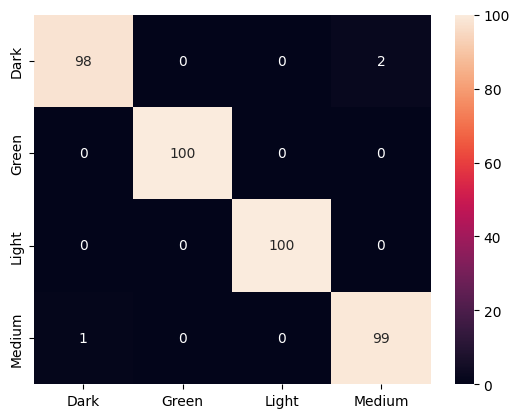

In [12]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt='d',xticklabels=class_names,yticklabels=class_names)
plt.show()

In [13]:
torch.save(model.state_dict(), r"C:\Users\IKBAR\uap_ML\src\model\resnet18.pkl")